# Reproduction of Fig. S5

Profiling of gene sets enriched in genomes with strong IDP propensity in ARF


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from functools import partial
from tqdm.notebook import tqdm
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.visualization import ColorUniversalDesign as CUD
metadata = Metadata()

In [2]:
idp_summary = pd.read_pickle(
    path2.data/'iupred2a'/'summary.pkl.bz2'
).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1)
idp_fw2rc1 = idp_summary[30,0.5].loc[[4,8]].sum() / idp_summary[30,0].loc[[4,8]].sum()

In [3]:
nts_summary = pd.read_pickle(path2.data/'kmer'/'nts_summary.pkl.bz2')
GC = nts_summary.T.eval('(G+C)/(G+C+A+T)*100')

In [4]:
ko_sets = pd.read_pickle(path2.data/'kofamscan'/'summary.pkl.bz2')
ko_list = pd.read_csv(path2.metadata/'ko_list', sep='\t', index_col=0)

ko_corr_idp = ko_sets.T.apply(partial(idp_fw2rc1.corr, method='spearman')).rename('rho')
results_idp = pd.concat([ko_corr_idp, ko_list['definition']], axis=1).dropna().sort_values(by='rho')

ko_corr_gc = ko_sets.T.apply(partial(GC.corr, method='spearman')).rename('rho')
results_gc = pd.concat([ko_corr_gc, ko_list['definition']], axis=1).dropna().sort_values(by='rho')

In [5]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

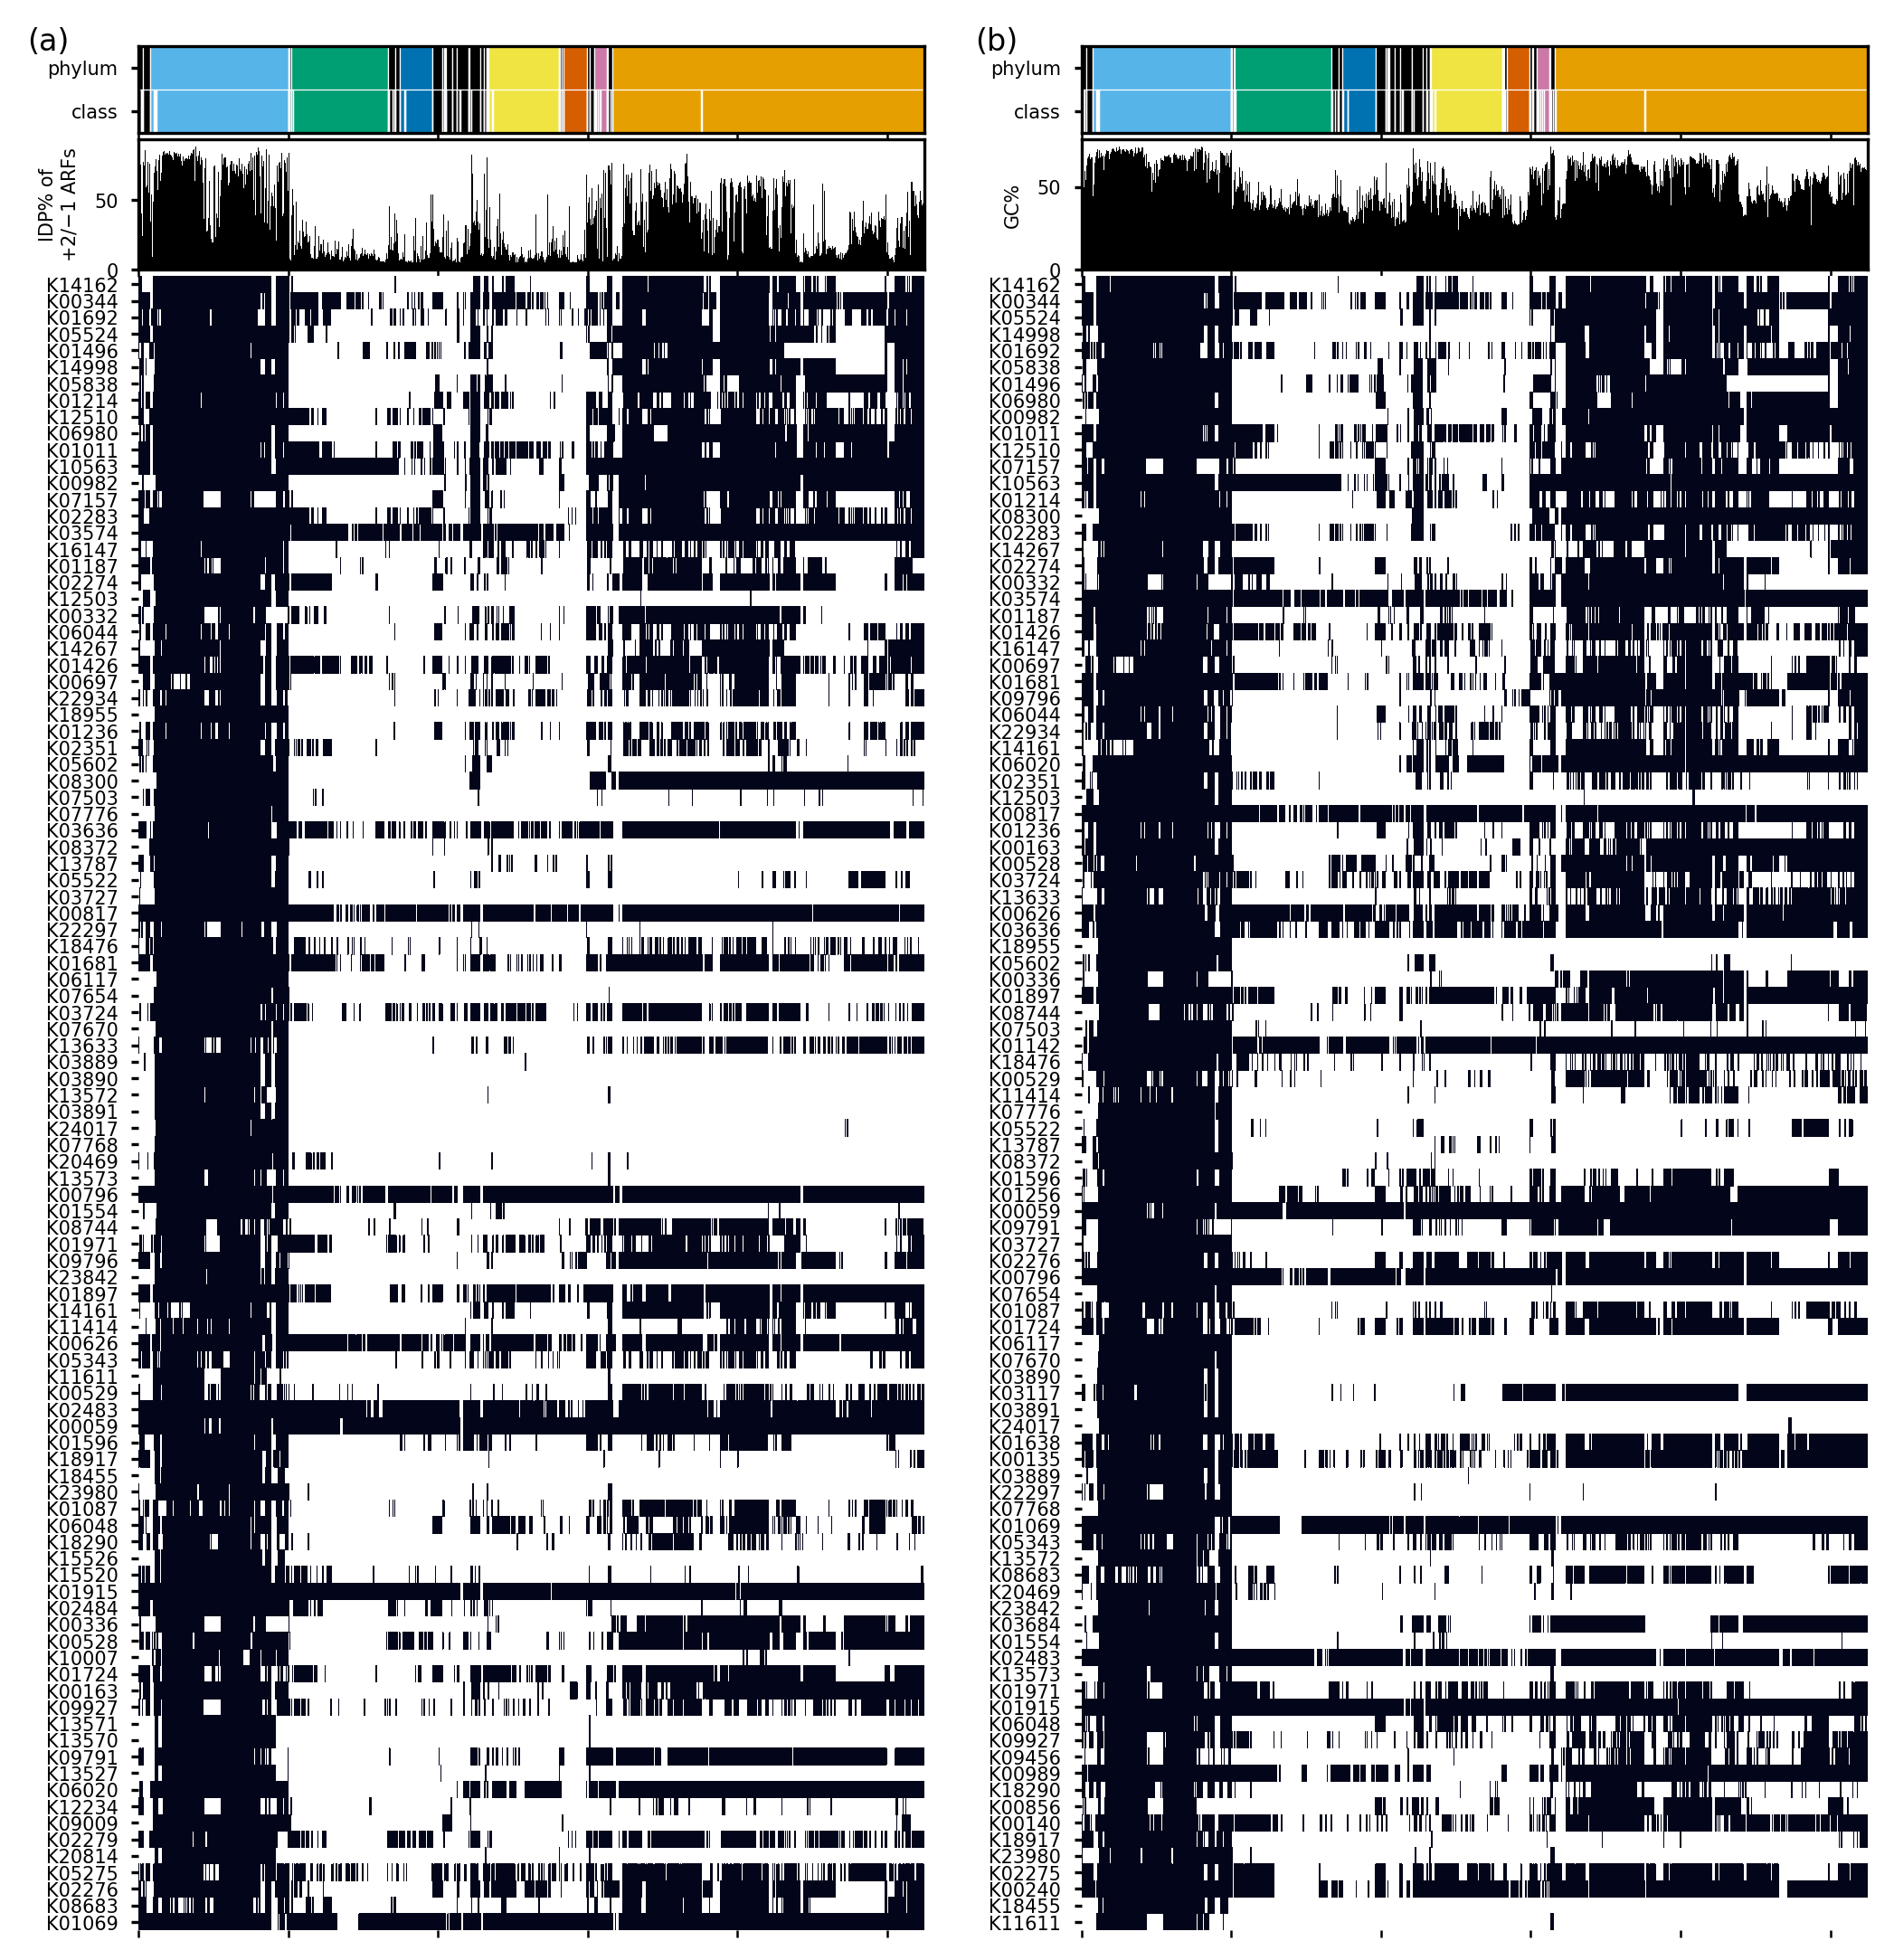

In [42]:
mm = 1 / 25.4
import seaborn as sns
with plt.rc_context({'font.size': 5, 'ytick.major.size': 2, 'ytick.labelsize': 5}):
    fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, figsize=(174*mm, 180*mm), gridspec_kw=dict(height_ratios=[1,1.5,19], hspace=0.01), dpi=300, sharex=True)
    ## phylogeny
    rect = []
    for w, x, fc in zip(phylum_counts, phylum_counts.cumsum(), phylum_color):
        rect.append(plt.Rectangle((x, 0), -w, 2, lw=0.3, ec='w', fc=fc))
    for p__, grp in gtdb_taxonomy.groupby('phylum'):
        base = (phylum_counts.cumsum() - phylum_counts)[p__]
        class_cnt = grp['class'].value_counts()[grp['class'].unique()]
        rect.extend([
            plt.Rectangle((base+x, 1), -w, 1, lw=0.3, ec='w', fc='None')
            for w, x in zip(class_cnt, class_cnt.cumsum())
        ])
        
    ax1.add_collection(PatchCollection(rect, match_original=True))
    ax1.set(xlim=(0, len(metadata.acc)), ylim=(2, 0))
    ax1.set(yticks=[0.5, 1.5], yticklabels=['phylum', 'class'])
    ax1.xaxis.set_tick_params(bottom=False, labelbottom=False)
    ax4.add_collection(PatchCollection(rect, match_original=True))
    ax4.set(xlim=(0, len(metadata.acc)), ylim=(2, 0))
    ax4.set(yticks=[0.5, 1.5], yticklabels=['phylum', 'class'])
    ax4.xaxis.set_tick_params(bottom=False, labelbottom=False)

    # IDP%
    (100*idp_fw2rc1).loc[acc_ordered['refseq']].plot.bar(ax=ax2, width=1, color='k')
    ax2.set_ylabel('IDP% of\n$+2$/$-1$ ARFs')
    
    # GC%
    GC.loc[acc_ordered['refseq']].plot.bar(ax=ax5, width=1, color='k')
    ax5.set_ylabel('GC%')
    
    # genes associated with high IDP%
    sns.heatmap(
        data := ko_sets.loc[results_idp.iloc[::-1][0:100].index, acc_ordered['refseq']] > 0,
        mask = (~data), xticklabels=False, yticklabels=True, cbar=False, ax=ax3
    )
    # genes associated with high GC%
    sns.heatmap(
        data := ko_sets.loc[results_gc.iloc[::-1][0:100].index, acc_ordered['refseq']] > 0,
        mask = (~data), xticklabels=False, yticklabels=True, cbar=False, ax=ax6
    )
    fig.subplots_adjust(top=0.99, bottom=0.01, right=0.99, left=0.06)
    fig.text(0   , 1, '(a)', va='top', ha='left', fontsize=8)
    fig.text(0.51, 1, '(b)', va='top', ha='left', fontsize=8)
    
    #fig.savefig('./Figs/FigS5.jpeg', dpi=200)
    fig.savefig('./Figs/FigS5.pdf')
    fig.patch.set_facecolor('w')
    fig.savefig('./Figs/FigS5.tif')
    